The patient characteristics of ME/CFS, Depression, and Both are quite similar, and the symptoms of these diseases overlap. Modern medical methods are insufficient to accurately distinguish ME/CFS, Depression, and Both based on symptoms alone. There is a significant risk of misdiagnosis or missed diagnosis. The purpose of this project is to develop and compare classification models that can diagnose and predict based on behavioral, clinical, and symptom characteristics, in order to accurately distinguish these three types of patients (ME/CFS, depression, and both), and determine the importance ranking of different symptom characteristics. We aim to reduce the risk of misdiagnosis or missed diagnosis in real life using machine learning models.

1. import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd  
import numpy as np 

import matplotlib.pyplot as plt  
import seaborn as sns 
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
from sklearn.dummy import DummyClassifier  

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, RocCurveDisplay
)

from itertools import cycle

Section B: Data Exploration

In [2]:
data = pd.read_csv('group_18.csv')
df = data
df.head()

,age,gender,sleep_quality_index,brain_fog_level,physical_pain_score,stress_level,depression_phq9_score,fatigue_severity_scale_score,pem_duration_hours,hours_of_sleep_per_night,pem_present,work_status,social_activity_level,exercise_frequency,meditation_or_mindfulness,diagnosis
0,67,Female,10.0,5.0,5.0,10.0,14.0,2.6,40.0,3.5,0.0,Not working,Very low,Sometimes,Yes,Depression
1,43,Male,3.0,8.0,4.0,10.0,25.0,8.4,36.0,5.0,1.0,Not working,Medium,Sometimes,No,Both
2,44,Male,9.0,5.0,2.0,7.0,6.0,6.5,11.0,5.2,1.0,Not working,Very High,Never,No,ME/CFS
3,32,Male,2.0,7.0,9.0,3.0,12.0,6.8,33.0,9.6,1.0,Not working,Very High,Sometimes,Yes,ME/CFS
4,25,Male,2.0,10.0,9.0,4.0,22.0,7.3,48.0,2.6,0.0,Partially working,Low,Daily,No,Depression


B.1 Data preprocessing

In [3]:
# 1. Check the shape and data types
print(df.shape)
print(df.dtypes)

(1620, 16)
age                               int64
gender                           object
sleep_quality_index             float64
brain_fog_level                 float64
physical_pain_score             float64
stress_level                    float64
depression_phq9_score           float64
fatigue_severity_scale_score    float64
pem_duration_hours              float64
hours_of_sleep_per_night        float64
pem_present                     float64
work_status                      object
social_activity_level            object
exercise_frequency               object
meditation_or_mindfulness        object
diagnosis                        object
dtype: object


In [4]:
# 2. View missing values
print(df.isnull().sum())

age                              0
gender                           0
sleep_quality_index             26
brain_fog_level                 23
physical_pain_score             20
stress_level                    21
depression_phq9_score           25
fatigue_severity_scale_score    27
pem_duration_hours              25
hours_of_sleep_per_night        27
pem_present                     27
work_status                     26
social_activity_level           28
exercise_frequency              24
meditation_or_mindfulness       24
diagnosis                        0
dtype: int64


In [5]:
df_imputed = df.copy()

numeric_features = [
    'age', 'sleep_quality_index', 'brain_fog_level', 'physical_pain_score',
    'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score',
    'pem_duration_hours', 'hours_of_sleep_per_night', 'pem_present',
]

categorical_features = [
    'gender', 'work_status', 
    'social_activity_level', 'exercise_frequency', 'meditation_or_mindfulness', 'diagnosis'
]


In [6]:
# 3. Numerical Feature - Mean Interpolation 
numeric_imputer = SimpleImputer(strategy='mean')
df_imputed[numeric_features] = numeric_imputer.fit_transform(df_imputed[numeric_features])

# with 1 decimal place
df_imputed[numeric_features] = df_imputed[numeric_features].round(1)

In [7]:
# 4. Classification feature - random interpolation
# Define random interpolation function
def random_impute(series):
    """Randomly interpolate a single categorical variable"""
    missing = series.isnull()
    if missing.sum() == 0:  
        return series
    series_filled = series.copy()
    series_filled.loc[missing] = np.random.choice(series.dropna(), missing.sum(), replace=True)
    return series_filled
for feature in categorical_features:
    df_imputed[feature] = random_impute(df_imputed[feature])

In [8]:
# 5. Verify interpolation results
print(df_imputed.isnull().sum())

age                             0
gender                          0
sleep_quality_index             0
brain_fog_level                 0
physical_pain_score             0
stress_level                    0
depression_phq9_score           0
fatigue_severity_scale_score    0
pem_duration_hours              0
hours_of_sleep_per_night        0
pem_present                     0
work_status                     0
social_activity_level           0
exercise_frequency              0
meditation_or_mindfulness       0
diagnosis                       0
dtype: int64


In [9]:
# 6. Generate interpolation report
print(f"sample size: {len(df)}")
print(f"Total number of missing values: {df.isnull().sum().sum()}")
print(f"Number of missing values after interpolation: {df_imputed.isnull().sum().sum()}")

sample size: 1620
Total number of missing values: 323
Number of missing values after interpolation: 0


In [10]:
# 7. Display interpolated statistical information
for feature in numeric_features:
    if df[feature].isnull().sum() > 0:
        imputed_value = numeric_imputer.statistics_[numeric_features.index(feature)]
        print(f"{feature}: mean = {imputed_value:.2f}, interpolated {df[feature].isnull().sum()} values")

sleep_quality_index: mean = 5.37, interpolated 26 values
brain_fog_level: mean = 5.58, interpolated 23 values
physical_pain_score: mean = 5.44, interpolated 20 values
stress_level: mean = 5.54, interpolated 21 values
depression_phq9_score: mean = 13.60, interpolated 25 values
fatigue_severity_scale_score: mean = 6.98, interpolated 27 values
pem_duration_hours: mean = 24.75, interpolated 25 values
hours_of_sleep_per_night: mean = 5.06, interpolated 27 values
pem_present: mean = 0.61, interpolated 27 values


In [11]:
# Save dataset
df_imputed.to_csv(r'data_imputed_clean.csv', index=False)

B.2 Visualization

<Figure size 800x600 with 0 Axes>

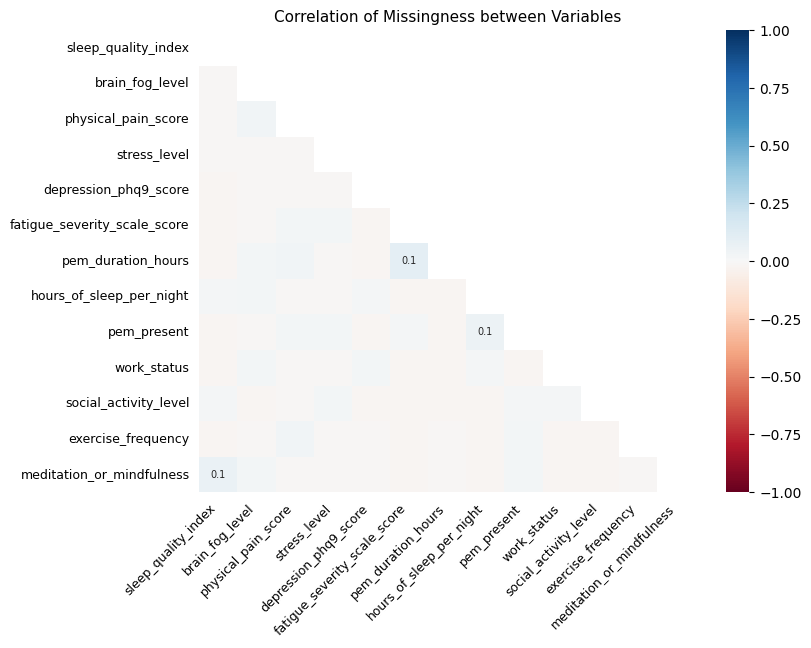

In [12]:
# B.2.1 heatmap：correlation of missingness between variables

plt.figure(figsize=(8,6))
msno.heatmap(df, figsize=(8, 6), fontsize=9)  
plt.title("Correlation of Missingness between Variables", fontsize=11)
plt.show()

In [13]:
df = df_imputed.copy()

In [14]:
# Basic dataset information
print(f"dataset shape: {df.shape}")
print(f"number of features: {df.shape[1] - 1}") 
print(f"sample size: {df.shape[0]}")

dataset shape: (1620, 16)
number of features: 15
sample size: 1620


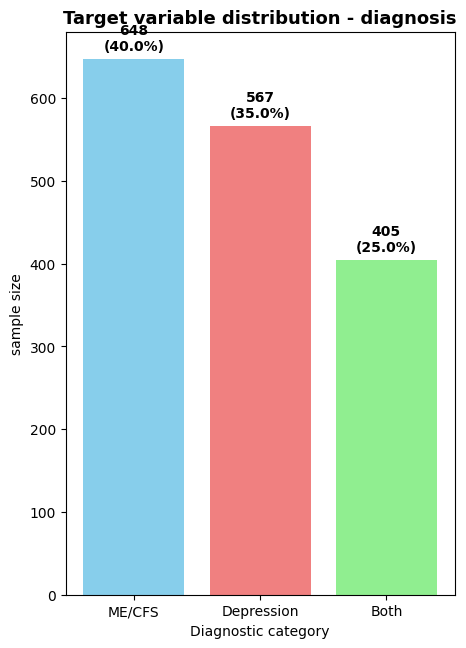

In [15]:
# B.2.2 Target variable analysis
plt.figure(figsize=(15, 14))

# Target variable distribution
plt.subplot(2, 3, 1)
diagnosis_counts = df['diagnosis'].value_counts()
diagnosis_perc = df['diagnosis'].value_counts(normalize=True) * 100

bars = plt.bar(diagnosis_counts.index, diagnosis_counts.values, 
               color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Target variable distribution - diagnosis', fontsize=13, fontweight='bold')
plt.xlabel('Diagnostic category')
plt.ylabel('sample size')

# Add percentage on column - adjust position and format
for i, (count, perc) in enumerate(zip(diagnosis_counts.values, diagnosis_perc.values)):
    plt.text(i, count + max(diagnosis_counts.values)*0.01,  
             f'{count}\n({perc:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout(pad=5.0)  
plt.show()

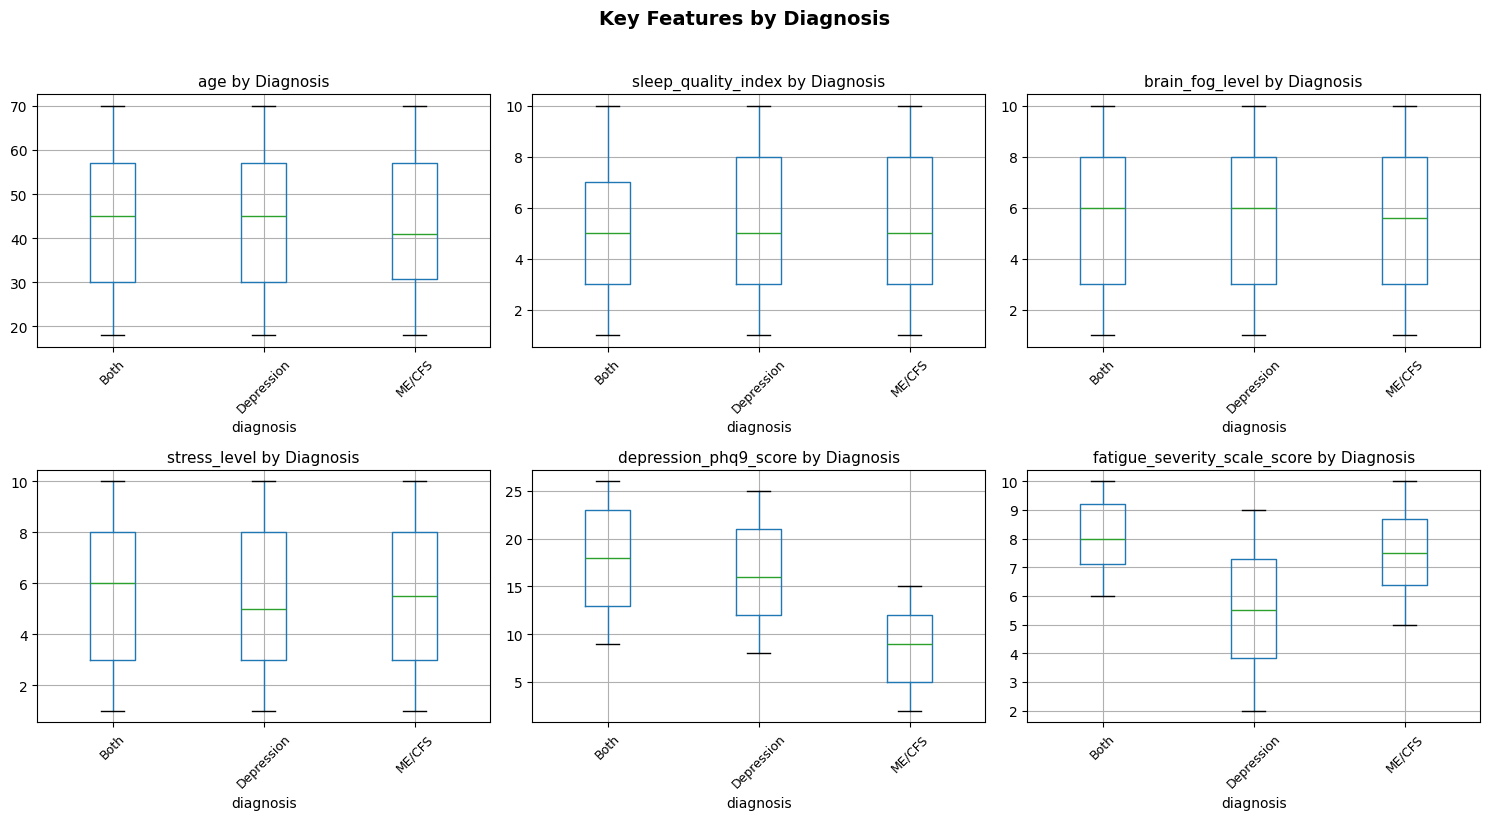

In [16]:
# B.2.3 Analysis of the Relationship between Features and Target Variables
# Create feature comparisons grouped by diagnosis
fig, axes = plt.subplots(2, 3, figsize=(15, 8)) 
key_features = [
    'age', 'sleep_quality_index', 'brain_fog_level', 
    'stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score'
]

for i, feature in enumerate(key_features):
    row, col = divmod(i, 3) 
    df.boxplot(column=feature, by='diagnosis', ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Diagnosis', fontsize=11)
    axes[row, col].set_xticklabels(
        axes[row, col].get_xticklabels(), rotation=45, fontsize=9
    )

plt.suptitle('Key Features by Diagnosis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

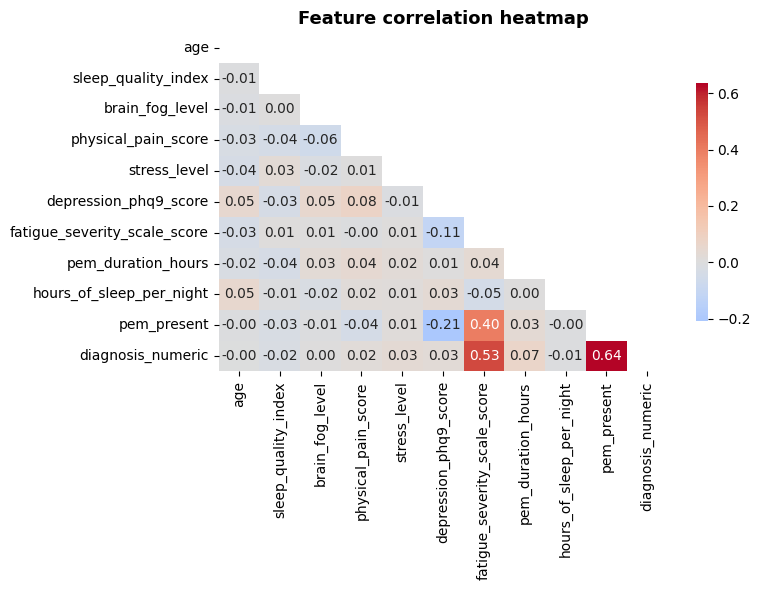

In [17]:
# B.2.4 Correlation analysis (with logical encoding of diagnosis severity)
plt.figure(figsize=(8, 6))  

df_corr = df.copy()

# Severity-based encoding
diagnosis_map = {'Depression': 0, 'ME/CFS': 1, 'Both': 2}
df_corr['diagnosis_numeric'] = df_corr['diagnosis'].map(diagnosis_map)

corr_features = numeric_features + ['diagnosis_numeric']
corr_matrix = df_corr[corr_features].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=False,   
    fmt='.2f',
    cbar_kws={"shrink": .7}  
)

plt.title('Feature correlation heatmap', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

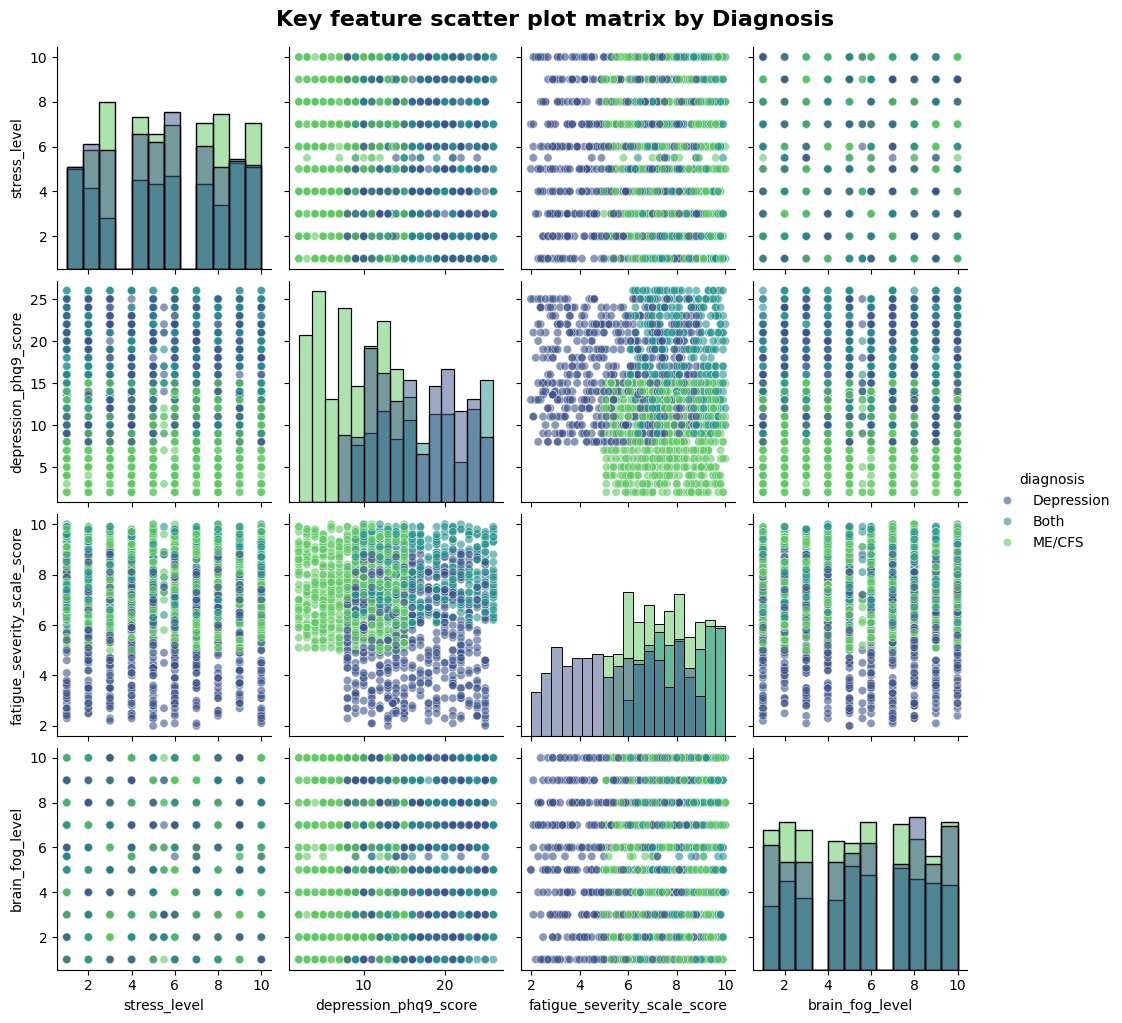

In [18]:
# B.2.5 Key feature scatter plot matrix
# Select the 4 most relevant features for scatter plot analysis
top_features = ['stress_level', 'depression_phq9_score', 'fatigue_severity_scale_score', 'brain_fog_level']
scatter_df = df[top_features + ['diagnosis']].copy()

if df['diagnosis'].dtype == 'object':
    diagnosis_map = {label: idx for idx, label in enumerate(df['diagnosis'].unique())}
    scatter_df['diagnosis_color'] = df['diagnosis'].map(diagnosis_map)
else:
    scatter_df['diagnosis_color'] = df['diagnosis']

plt.figure(figsize=(12, 10))
sns.pairplot(scatter_df, vars=top_features, hue='diagnosis', 
             palette='viridis', diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Key feature scatter plot matrix by Diagnosis', y=1.02, fontsize=16, fontweight='bold')
plt.show()

Section C: Model Building

In [19]:
# read the cleaned data
data = pd.read_csv('data_imputed_rondom.csv')

In [20]:
# preparation features (x) and target variable (y)
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

print(f"Characteristic data shape: {X.shape}")
print(f"Shape of the target variable: {y.shape}")

Characteristic data shape: (1620, 15)
Shape of the target variable: (1620,)


C.1 Encoding

In [21]:
# Define the encoding mapping to align with your friend's scheme
encoding_map = {'Depression': 0, 'ME/CFS': 1, 'Both': 2}

# Encode categorical features in X
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' or not pd.api.types.is_numeric_dtype(X[column]):
        print(f"Encoding column: {column}")
        # Use the mapping for specific columns if needed, or keep LabelEncoder for general features
        # For simplicity, we'll keep LabelEncoder for features but ensure target uses our mapping
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))
        label_encoders[column] = le

# Encode target variable y using the specific mapping
if y.dtype == 'object':
    y = y.map(encoding_map)
    # Convert to numpy array if needed and ensure dtype is integer
    y = y.values.astype(int)
    print(f"Target variable encoding: {encoding_map}")

Encoding column: gender
Encoding column: work_status
Encoding column: social_activity_level
Encoding column: exercise_frequency
Encoding column: meditation_or_mindfulness
Target variable encoding: {'Depression': 0, 'ME/CFS': 1, 'Both': 2}


C.2 Divide the data into a training set and a test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"training set: {X_train.shape[0]} samples")
print(f"test set: {X_test.shape[0]} samples")

training set: 1296 samples
test set: 324 samples


C.3 Hyperparameter tuning

In [23]:
def display_tuning_results(model_name, param_grid, grid_search_results, top_n=5):
    """Hyperparameter tuning"""
    print(f"\n=== {model_name} Hyperparameter Tuning ===")
    
    print(f"\n--- Hyperparameter Search Space ---")
    for param, values in param_grid.items():
        print(f"{param:20} {values}")
    
    # Obtain and sort the results
    results_df = pd.DataFrame(grid_search_results.cv_results_)
    results_sorted = results_df.sort_values('mean_test_score', ascending=False)
    top_results = results_sorted.head(top_n)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    
    print(f"\n--- Best Performing Combinations (Top {top_n}) ---")
    
    # Create table data
    table_data = []
    for _, row in top_results.iterrows():
        params = row['params']
        table_data.append({
            'Rank': f"#{int(row['rank_test_score'])}",
            'Parameters': str(params),
            'Score': f"{row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}"
        })
    
    top_df = pd.DataFrame(table_data)
    print(top_df.to_string(index=False))
    
    print(f"\n Best parameters: {grid_search_results.best_params_}")
    print(f" Best cross-validation score: {grid_search_results.best_score_:.4f}")
    print("=" * 60)
    
    return grid_search_results.best_estimator_

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 3.1 Multinomial Logistic Regression Hyperparameter Tuning
logistic_model = LogisticRegression(multi_class='multinomial', random_state=42)
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg'],
    'max_iter': [1000]
}

logistic_grid = GridSearchCV(logistic_model, logistic_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
logistic_grid.fit(X_train, y_train)
best_logistic = display_tuning_results("Multinomial Logistic Regression", logistic_param_grid, logistic_grid)


print()

# 3.2 Decision Tree Hyperparameter Tuning
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

decision_tree_grid = GridSearchCV(decision_tree_model, decision_tree_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
decision_tree_grid.fit(X_train, y_train)
best_decision_tree = display_tuning_results("Decision Tree", decision_tree_param_grid, decision_tree_grid)

print()

# 3.3 Random Forest Hyperparameter Tuning
random_forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

random_forest_grid = GridSearchCV(random_forest_model, random_forest_param_grid, cv=cv, scoring='accuracy', n_jobs=-1, return_train_score=True)
random_forest_grid.fit(X_train, y_train)
best_rf = display_tuning_results("Random Forest", random_forest_param_grid, random_forest_grid)

# Train the final model using the optimal parameters
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    **random_forest_grid.best_params_
)
rf_model.fit(X_train, y_train)


=== Multinomial Logistic Regression Hyperparameter Tuning ===

--- Hyperparameter Search Space ---
C                    [0.01, 0.1, 1, 10, 100]
penalty              ['l2']
solver               ['lbfgs', 'newton-cg']
max_iter             [1000]

--- Best Performing Combinations (Top 5) ---
Rank                                                           Parameters           Score
  #1       {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'} 0.7978 ± 0.0291
  #1   {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'} 0.7978 ± 0.0291
  #1     {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'} 0.7978 ± 0.0272
  #1 {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'} 0.7978 ± 0.0272
  #1  {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'} 0.7978 ± 0.0272

 Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
 Best cross-validation score: 0.7978


=== Decision Tree Hyperparameter Tuning ===

---

,n_estimators,300
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Section D: Model Evaluation

D.1 Model Evaluation With Cross-Validation

In [24]:
GLOBAL_CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6.1. Multinomial Logistic Regression
print("\n" + "=" * 50)
print("1. MULTINOMIAL LOGISTIC REGRESSION")
print("=" * 50)

best_logistic = logistic_grid.best_estimator_

cv_scores_logistic = cross_validate(best_logistic, X_train, y_train, cv=GLOBAL_CV, 
                                   scoring='accuracy', return_train_score=True, 
                                   return_estimator=True)

print("Per-fold results:")
for i, (train_idx, val_idx) in enumerate(GLOBAL_CV.split(X_train, y_train)):
    fold_model = cv_scores_logistic['estimator'][i]
    X_val_fold = X_train.iloc[val_idx] if hasattr(X_train, 'iloc') else X_train[val_idx]
    y_val_fold = y_train.iloc[val_idx] if hasattr(y_train, 'iloc') else y_train[val_idx]
    
    y_val_pred = fold_model.predict(X_val_fold)
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"  Fold {i+1}: {fold_accuracy:.4f}")

print(f"\nAggregate results:")
print(f"  Training accuracy: {cv_scores_logistic['train_score'].mean():.4f} (+/- {cv_scores_logistic['train_score'].std() * 2:.4f})")
print(f"  Validation accuracy: {cv_scores_logistic['test_score'].mean():.4f} (+/- {cv_scores_logistic['test_score'].std() * 2:.4f})")
print(f"  Fit time: {cv_scores_logistic['fit_time'].mean():.4f}s per fold")

best_logistic_final = logistic_grid.best_estimator_
best_logistic_final.fit(X_train, y_train)

# 6.2. Decision Tree Classifier
print("\n" + "=" * 50)
print("2. DECISION TREE CLASSIFIER")
print("=" * 50)

best_decision_tree = decision_tree_grid.best_estimator_

cv_scores_tree = cross_validate(best_decision_tree, X_train, y_train, cv=GLOBAL_CV, 
                               scoring='accuracy', return_train_score=True, 
                               return_estimator=True)

print("Per-fold results:")
for i, (train_idx, val_idx) in enumerate(GLOBAL_CV.split(X_train, y_train)):
    fold_model = cv_scores_tree['estimator'][i]
    X_val_fold = X_train.iloc[val_idx] if hasattr(X_train, 'iloc') else X_train[val_idx]
    y_val_fold = y_train.iloc[val_idx] if hasattr(y_train, 'iloc') else y_train[val_idx]
    
    y_val_pred = fold_model.predict(X_val_fold)
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"  Fold {i+1}: {fold_accuracy:.4f}")

print(f"\nAggregate results:")
print(f"  Training accuracy: {cv_scores_tree['train_score'].mean():.4f} (+/- {cv_scores_tree['train_score'].std() * 2:.4f})")
print(f"  Validation accuracy: {cv_scores_tree['test_score'].mean():.4f} (+/- {cv_scores_tree['test_score'].std() * 2:.4f})")
print(f"  Fit time: {cv_scores_tree['fit_time'].mean():.4f}s per fold")

best_decision_tree_final = decision_tree_grid.best_estimator_
best_decision_tree_final.fit(X_train, y_train)

# 6.3. Random Forest Classifier
print("\n" + "=" * 50)
print("3. RANDOM FOREST CLASSIFIER")
print("=" * 50)

best_random_forest = random_forest_grid.best_estimator_

cv_scores_forest = cross_validate(best_random_forest, X_train, y_train, cv=GLOBAL_CV, 
                                 scoring='accuracy', return_train_score=True, 
                                 return_estimator=True)

print("Per-fold results:")
for i, (train_idx, val_idx) in enumerate(GLOBAL_CV.split(X_train, y_train)):
    fold_model = cv_scores_forest['estimator'][i]
    X_val_fold = X_train.iloc[val_idx] if hasattr(X_train, 'iloc') else X_train[val_idx]
    y_val_fold = y_train.iloc[val_idx] if hasattr(y_train, 'iloc') else y_train[val_idx]
    
    y_val_pred = fold_model.predict(X_val_fold)
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"  Fold {i+1}: {fold_accuracy:.4f}")

print(f"\nAggregate results:")
print(f"  Training accuracy: {cv_scores_forest['train_score'].mean():.4f} (+/- {cv_scores_forest['train_score'].std() * 2:.4f})")
print(f"  Validation accuracy: {cv_scores_forest['test_score'].mean():.4f} (+/- {cv_scores_forest['test_score'].std() * 2:.4f})")
print(f"  Fit time: {cv_scores_forest['fit_time'].mean():.4f}s per fold")

best_random_forest_final = random_forest_grid.best_estimator_
best_random_forest_final.fit(X_train, y_train)

# Final model comparison
print("\n" + "=" * 60)
print("FINAL MODEL COMPARISON")
print("=" * 60)

models = {
    'Logistic Regression': best_logistic_final,
    'Decision Tree': best_decision_tree_final,
    'Random Forest': best_random_forest_final
}

# Evaluate the final model on the test set
print("\nTest Set Performance:")
print("-" * 30)
for name, model in models.items():
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{name:<20}: {test_accuracy:.4f}")


1. MULTINOMIAL LOGISTIC REGRESSION
Per-fold results:
  Fold 1: 0.7846
  Fold 2: 0.8301
  Fold 3: 0.8340
  Fold 4: 0.7606
  Fold 5: 0.7799

Aggregate results:
  Training accuracy: 0.8050 (+/- 0.0164)
  Validation accuracy: 0.7978 (+/- 0.0582)
  Fit time: 0.3194s per fold

2. DECISION TREE CLASSIFIER
Per-fold results:
  Fold 1: 0.8038
  Fold 2: 0.8340
  Fold 3: 0.8533
  Fold 4: 0.7876
  Fold 5: 0.8417

Aggregate results:
  Training accuracy: 0.8339 (+/- 0.0152)
  Validation accuracy: 0.8241 (+/- 0.0490)
  Fit time: 0.0031s per fold

3. RANDOM FOREST CLASSIFIER
Per-fold results:
  Fold 1: 0.8154
  Fold 2: 0.8494
  Fold 3: 0.8610
  Fold 4: 0.7799
  Fold 5: 0.8417

Aggregate results:
  Training accuracy: 1.0000 (+/- 0.0000)
  Validation accuracy: 0.8295 (+/- 0.0579)
  Fit time: 0.3625s per fold

FINAL MODEL COMPARISON

Test Set Performance:
------------------------------
Logistic Regression : 0.7870
Decision Tree       : 0.8395
Random Forest       : 0.8241


D.2 Comprehensive Evaluation and Confusion Matrix


Baseline Accuracy (Majority Class): 40.12%

PERFORMANCE COMPARISON:
Model                        Test Acc   Precision  Recall     F1-Score   Train-Test Gap vs Baseline 
Logistic Regression          78.70%    77.98%    77.54%    77.72%    1.77%        +38.58%
Decision Tree                83.95%    86.33%    80.70%    81.52%    -0.69%        +43.83%
Random Forest                82.41%    83.48%    79.49%    80.17%    17.59%        +42.28%

CONFUSION MATRICES


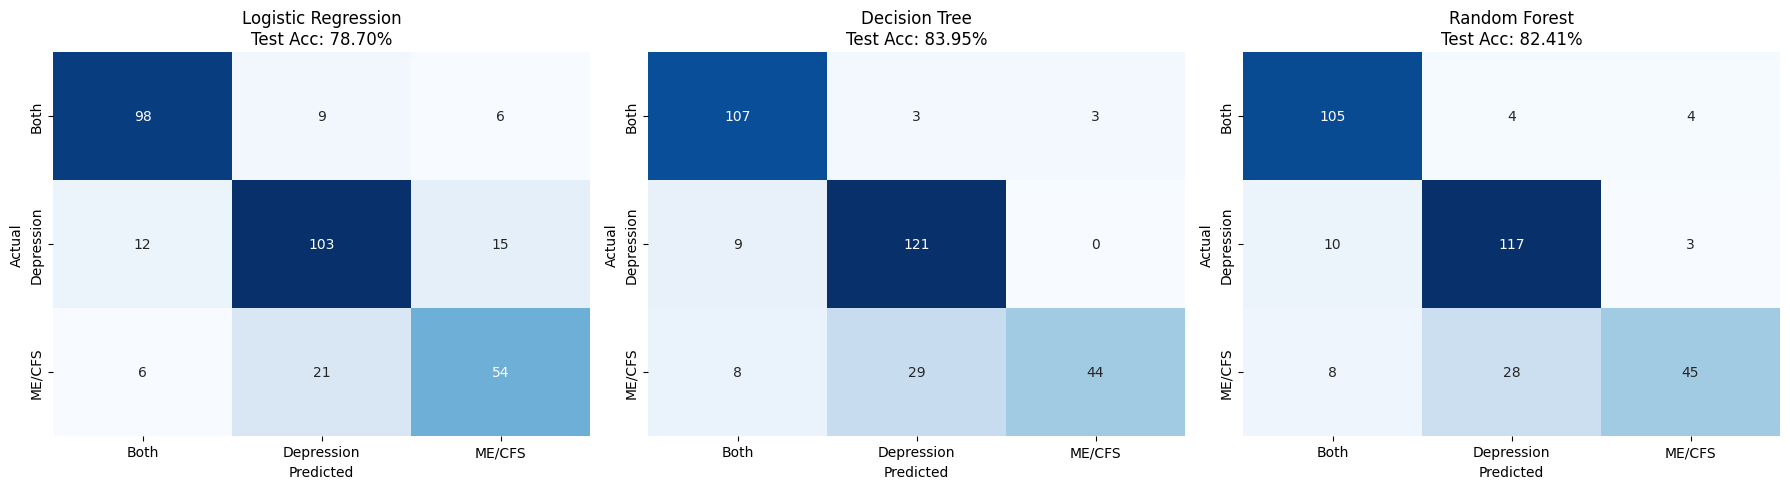

In [25]:
def concise_model_comparison(models_dict, X_train, X_test, y_train, y_test, class_names):
    """
    comprehensive evaluation and confusion matrix
    """
    results = {}
    
    # Calculate the baseline accuracy rate
    majority_class = np.bincount(y_train).argmax()
    baseline_predictions = np.full_like(y_test, majority_class)
    baseline_accuracy = accuracy_score(y_test, baseline_predictions)
    
    # Collect all the model results
    for model_name, model in models_dict.items():
        # Training and Prediction
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Parameter
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        macro_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
        macro_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
        macro_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        
        results[model_name] = {
            'test_accuracy': test_accuracy,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'train_test_gap': train_accuracy - test_accuracy,
            'baseline_improvement': test_accuracy - baseline_accuracy
        }
    
    # Output summary table
    print(f"\nBaseline Accuracy (Majority Class): {baseline_accuracy:.2%}")
    print("\nPERFORMANCE COMPARISON:")
    print("=" * 95)
    print(f"{'Model':<28} {'Test Acc':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Train-Test Gap':<14} {'vs Baseline':<12}")
    print("=" * 95)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<28} {metrics['test_accuracy']:.2%}    {metrics['macro_precision']:.2%}    "
              f"{metrics['macro_recall']:.2%}    {metrics['macro_f1']:.2%}    {metrics['train_test_gap']:.2%}        "
              f"+{metrics['baseline_improvement']:.2%}")
    
    # Draw the confusion matrix for each model
    print("\n" + "=" * 80)
    print("CONFUSION MATRICES")
    print("=" * 80)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_test_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes[idx], cbar=False)
        axes[idx].set_title(f'{model_name}\nTest Acc: {results[model_name]["test_accuracy"]:.2%}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    return results

models_to_compare = {
    'Logistic Regression': best_logistic_final,
    'Decision Tree': best_decision_tree_final, 
    'Random Forest': best_random_forest_final
}

# Assumed category name
class_names = ['Both', 'Depression', 'ME/CFS']

# Carry out comparison
results = concise_model_comparison(models_to_compare, X_train, X_test, y_train, y_test, class_names)

D.3 ROC/AUC analysis

STARTING ROC/AUC ANALYSIS...
COMPREHENSIVE ROC/AUC EVALUATION

Analysis Purpose:
- ROC curves visualize the trade-off between true positive rate and false positive rate
- AUC measures the model's ability to distinguish between classes
- One-vs-Rest approach handles multi-class classification
- Higher AUC indicates better ranking and discrimination capability


 LOGISTIC REGRESSION - ROC/AUC Analysis
--------------------------------------------------
Both vs Rest: AUC = 0.9630
Depression vs Rest: AUC = 0.9196
ME/CFS vs Rest: AUC = 0.9053
Macro-average AUC: 0.9309


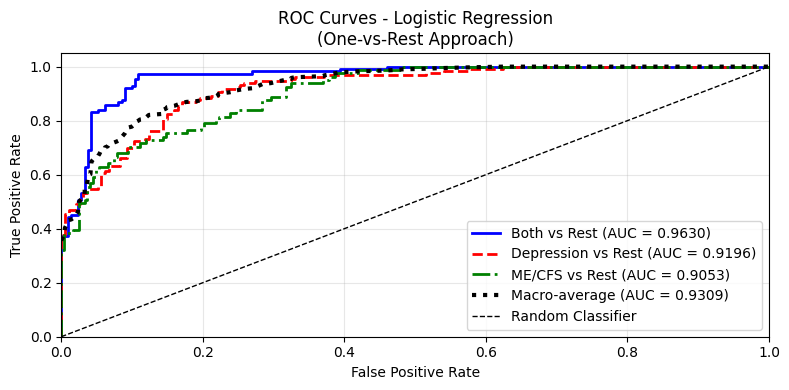


 DECISION TREE - ROC/AUC Analysis
--------------------------------------------------
Both vs Rest: AUC = 0.9689
Depression vs Rest: AUC = 0.9493
ME/CFS vs Rest: AUC = 0.9233
Macro-average AUC: 0.9472


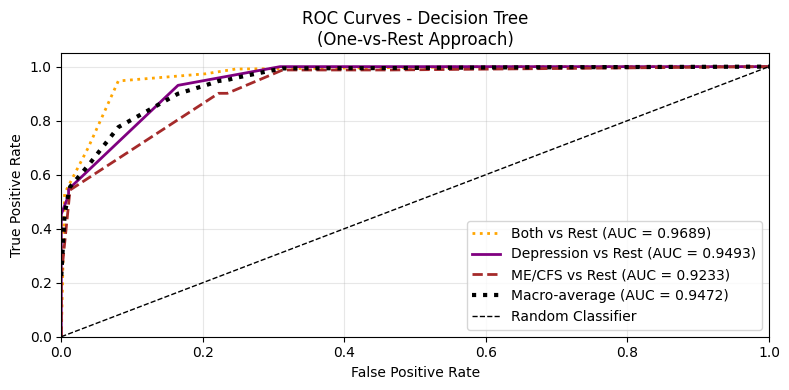


 RANDOM FOREST - ROC/AUC Analysis
--------------------------------------------------
Both vs Rest: AUC = 0.9686
Depression vs Rest: AUC = 0.9462
ME/CFS vs Rest: AUC = 0.9354
Macro-average AUC: 0.9512


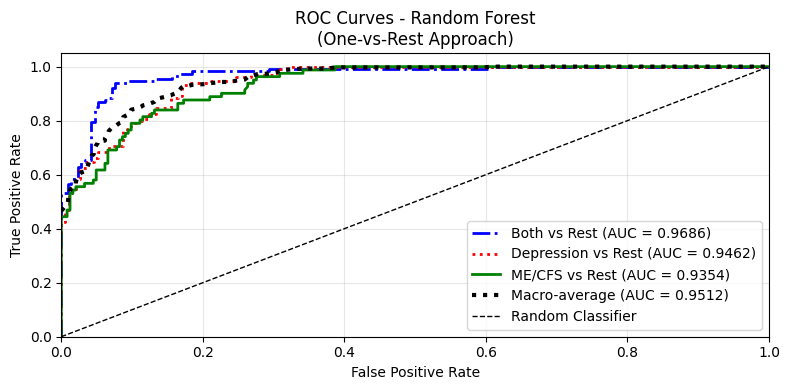


AUC VALUE COMPARISON SUMMARY
              Model Both AUC Depression AUC ME/CFS AUC Macro AUC
Logistic Regression   0.9630         0.9196     0.9053    0.9309
      Decision Tree   0.9689         0.9493     0.9233    0.9472
      Random Forest   0.9686         0.9462     0.9354    0.9512

BEST PERFORMING MODELS BY AUC
Both AUC: Decision Tree (0.9689)
Depression AUC: Decision Tree (0.9493)
ME/CFS AUC: Random Forest (0.9354)
Macro AUC: Random Forest (0.9512)

PROBABILITY CALIBRATION ANALYSIS


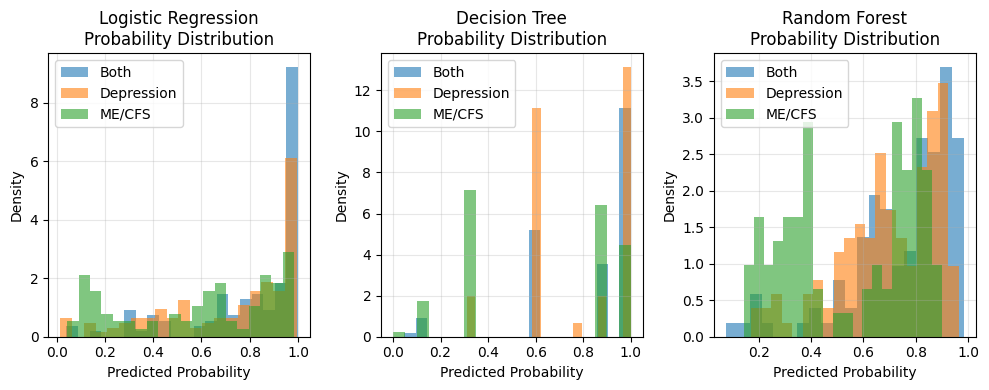


INTERPRETATION OF RESULTS

AUC Interpretation Guide:
- 0.90-1.00: Excellent discrimination
- 0.80-0.90: Good discrimination  
- 0.70-0.80: Fair discrimination
- 0.60-0.70: Poor discrimination
- 0.50-0.60: No discrimination (random)

Key Insights:
1. Models with higher AUC have better ranking capability
2. Consistent performance across classes indicates balanced learning
3. Macro-AUC provides overall discrimination assessment
4. Probability distributions show model confidence patterns


ROC/AUC ANALYSIS COMPLETED

Summary:
- ROC curves and AUC values provide insight into model discrimination capability
- One-vs-Rest approach effectively handles multi-class evaluation
- Probability calibration analysis reveals model confidence patterns
- Combined with accuracy metrics, this provides comprehensive model assessment



In [26]:
def analyze_roc_auc(models_dict, X_test, y_test, class_names):
    """
    Analysis of the ROC curve and AUC value of the model - One-vs-Rest method
    """
    
    # Binaryize the target variable (one-to-many)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = len(class_names)
    
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
    linestyles = cycle(['-', '--', '-.', ':'])
    
    roc_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n {model_name.upper()} - ROC/AUC Analysis")
        print("-" * 50)
        
        # Prediction probability
        y_score = model.predict_proba(X_test)
        
        # Calculate the ROC and AUC for each category
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            print(f"{class_names[i]} vs Rest: AUC = {roc_auc[i]:.4f}")
        
        # Calculate the macro average AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)
        
        print(f"Macro-average AUC: {macro_auc:.4f}")
        
        # Draw the ROC curve
        plt.figure(figsize=(8, 4))
        
        for i, color, linestyle in zip(range(n_classes), colors, linestyles):
            plt.plot(fpr[i], tpr[i], color=color, linestyle=linestyle, lw=2,
                    label=f'{class_names[i]} vs Rest (AUC = {roc_auc[i]:.4f})')
        
        # Draw the average ROC curve for the macroscopic classification
        plt.plot(all_fpr, mean_tpr, color='black', linestyle=':', lw=3,
                label=f'Macro-average (AUC = {macro_auc:.4f})')
        
        # Draw the diagonal line
        plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {model_name}\n(One-vs-Rest Approach)')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        roc_results[model_name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'macro_auc': macro_auc,
            'y_score': y_score
        }
    
    return roc_results

def create_auc_comparison(roc_results, class_names):
    """
    Create a summary of AUC value comparisons
    """
    print("\n" + "=" * 80)
    print("AUC VALUE COMPARISON SUMMARY")
    print("=" * 80)
    
    # Create a comparison table
    comparison_data = []
    for model_name, metrics in roc_results.items():
        row = {'Model': model_name}
        for i, class_name in enumerate(class_names):
            row[f'{class_name} AUC'] = f"{metrics['roc_auc'][i]:.4f}"
        row['Macro AUC'] = f"{metrics['macro_auc']:.4f}"
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    # Identify the best model for each dimension
    print("\n" + "=" * 60)
    print("BEST PERFORMING MODELS BY AUC")
    print("=" * 60)
    
    for i, class_name in enumerate(class_names):
        best_model = max(roc_results.items(), key=lambda x: x[1]['roc_auc'][i])
        print(f"{class_name} AUC: {best_model[0]} ({best_model[1]['roc_auc'][i]:.4f})")
    
    best_macro = max(roc_results.items(), key=lambda x: x[1]['macro_auc'])
    print(f"Macro AUC: {best_macro[0]} ({best_macro[1]['macro_auc']:.4f})")

def analyze_probability_calibration(models_dict, X_test, y_test, class_names):
    """
    Analyze the probability calibration of the model
    """
    print("\n" + "=" * 80)
    print("PROBABILITY CALIBRATION ANALYSIS")
    print("=" * 80)
    
    plt.figure(figsize=(10, 4))
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        # Obtain the predicted probability
        y_prob = model.predict_proba(X_test)
        
        plt.subplot(1, 3, idx + 1)
        
        # Draw the probability distribution for each category
        for i, class_name in enumerate(class_names):
            class_probs = y_prob[y_test == i, i]
            if len(class_probs) > 0:
                plt.hist(class_probs, bins=20, alpha=0.6, label=class_name, density=True)
        
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title(f'{model_name}\nProbability Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def comprehensive_roc_analysis(models_dict, X_test, y_test, class_names):
    """
    Comprehensive ROC/AUC analysis
    """
    print("COMPREHENSIVE ROC/AUC EVALUATION")
    print("=" * 80)
    print("""
Analysis Purpose:
- ROC curves visualize the trade-off between true positive rate and false positive rate
- AUC measures the model's ability to distinguish between classes
- One-vs-Rest approach handles multi-class classification
- Higher AUC indicates better ranking and discrimination capability
""")
    
    # 1. ROC curve and AUC analysis
    roc_results = analyze_roc_auc(models_dict, X_test, y_test, class_names)
    
    # 2. Summary of AUC Comparison
    create_auc_comparison(roc_results, class_names)
    
    # 3. Probability calibration analysis
    analyze_probability_calibration(models_dict, X_test, y_test, class_names)
    
    # 4. Performance explanation
    print("\n" + "=" * 80)
    print("INTERPRETATION OF RESULTS")
    print("=" * 80)
    print("""
AUC Interpretation Guide:
- 0.90-1.00: Excellent discrimination
- 0.80-0.90: Good discrimination  
- 0.70-0.80: Fair discrimination
- 0.60-0.70: Poor discrimination
- 0.50-0.60: No discrimination (random)

Key Insights:
1. Models with higher AUC have better ranking capability
2. Consistent performance across classes indicates balanced learning
3. Macro-AUC provides overall discrimination assessment
4. Probability distributions show model confidence patterns
""")
    
    return roc_results

# Conduct ROC/AUC analysis
print("STARTING ROC/AUC ANALYSIS...")
roc_results = comprehensive_roc_analysis(models_to_compare, X_test, y_test, class_names)

print("\n" + "=" * 80)
print("ROC/AUC ANALYSIS COMPLETED")
print("=" * 80)
print("""
Summary:
- ROC curves and AUC values provide insight into model discrimination capability
- One-vs-Rest approach effectively handles multi-class evaluation
- Probability calibration analysis reveals model confidence patterns
- Combined with accuracy metrics, this provides comprehensive model assessment
""")

D.4 Cost-Benefit Matrix Analysis

In [27]:
def analyze_cost_benefit(models_dict, X_test, y_test, class_names):
    """
    cost-benefit matrix analysis
    """
    
    # Cost matrix
    cost_matrix = np.array([
        # Predicted: Both, Depression, ME/CFS
        [0,      -4,     -3],    # Actual: Both
        [-5,      0,      -2],   # Actual: Depression
        [-2,     -10,      0]     # Actual: ME/CFS
    ])
    
    print("Cost-Benefit Matrix:")
    cost_df = pd.DataFrame(cost_matrix, 
                          index=[f'Actual {name}' for name in class_names],
                          columns=[f'Predicted {name}' for name in class_names])
    print(cost_df)
    print("\nInterpretation: Negative values = costs/penalties, Zero = correct classification")
    
    cost_results = {}
    
    for model_name, model in models_dict.items():
        print(f"\n{model_name.upper()}")
        print("-" * 40)
        
        # prediction
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        # Calculate the cost-effectiveness
        total_cost = np.sum(cm * cost_matrix)
        avg_cost_per_sample = total_cost / len(y_test)
        total_benefit = -total_cost
        
        print(f"Total cost: {total_cost:.2f}")
        print(f"Average cost per sample: {avg_cost_per_sample:.2f}")
        print(f"Total benefit: {total_benefit:.2f}")
        
        # Analysis of each type of cost
        print("Cost breakdown by actual class:")
        for i, class_name in enumerate(class_names):
            class_cost = np.sum(cm[i] * cost_matrix[i])
            print(f"  {class_name}: {class_cost:.2f}")
        
        cost_results[model_name] = {
            'total_cost': total_cost,
            'avg_cost_per_sample': avg_cost_per_sample,
            'total_benefit': total_benefit,
            'confusion_matrix': cm
        }
    
    # Cost-benefit comparisons
    print("\n" + "=" * 60)
    print("COST-BENEFIT COMPARISON")
    print("=" * 60)
    
    comparison_data = []
    for model_name, metrics in cost_results.items():
        comparison_data.append({
            'Model': model_name,
            'Total Cost': f"{metrics['total_cost']:.2f}",
            'Avg Cost/Sample': f"{metrics['avg_cost_per_sample']:.2f}",
            'Total Benefit': f"{metrics['total_benefit']:.2f}"
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    
    return cost_results, cost_matrix

# Conduct cost-benefit analysis
cost_results, cost_matrix = analyze_cost_benefit(models_to_compare, X_test, y_test, class_names)

print()

def generate_cost_analysis_conclusion():
    conclusion = """
KEY INSIGHTS FROM COST-BENEFIT ANALYSIS
===========================================================

1. Random Forest demonstrates superior performance** with the lowest total cost (-256.00) and best cost efficiency (-0.79 per sample)

2. ME/CFS classification remains the most challenging** with the highest misclassification costs across all models, particularly for Decision Tree (-140.00)

3. Logistic Regression shows the most balanced class performance** with relatively even cost distribution across all three conditions

4. Decision Tree exhibits the highest overall costs** (-290.00), indicating suboptimal performance for clinical deployment

5. Cost matrix effectively prioritized clinical risks** with ME/CFS misdiagnoses carrying the heaviest penalties as intended
===========================================================
"""
    return conclusion

print(generate_cost_analysis_conclusion())



Cost-Benefit Matrix:
                   Predicted Both  Predicted Depression  Predicted ME/CFS
Actual Both                     0                    -4                -3
Actual Depression              -5                     0                -2
Actual ME/CFS                  -2                   -10                 0

Interpretation: Negative values = costs/penalties, Zero = correct classification

LOGISTIC REGRESSION
----------------------------------------
Total cost: -366.00
Average cost per sample: -1.13
Total benefit: 366.00
Cost breakdown by actual class:
  Both: -54.00
  Depression: -90.00
  ME/CFS: -222.00

DECISION TREE
----------------------------------------
Total cost: -372.00
Average cost per sample: -1.15
Total benefit: 372.00
Cost breakdown by actual class:
  Both: -21.00
  Depression: -45.00
  ME/CFS: -306.00

RANDOM FOREST
----------------------------------------
Total cost: -380.00
Average cost per sample: -1.17
Total benefit: 380.00
Cost breakdown by actual class:
  Bo

Section E: Implementation and Business Case Recommendations - Random Forest Model

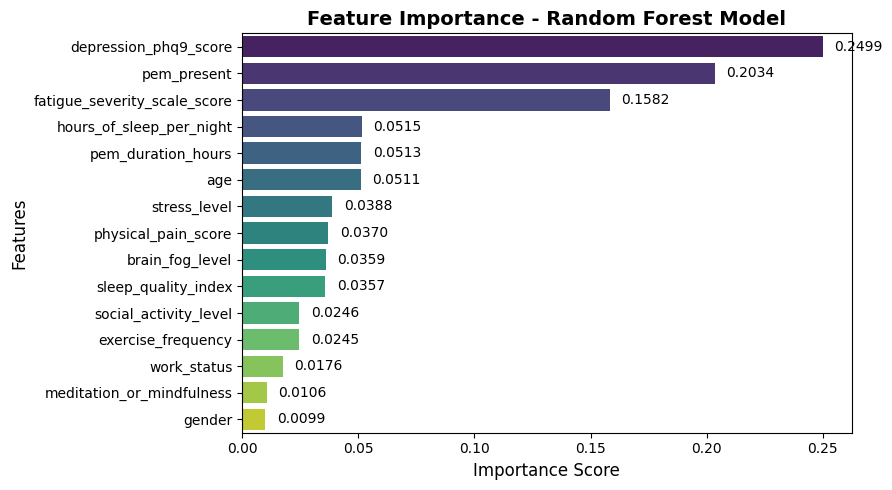

In [28]:
# Feature Importance Graph
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(9, 5)) 
ax = sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')

# Add numerical labels to each bar
for i, (importance, feature) in enumerate(zip(feature_importance.head(15)['importance'], 
                                              feature_importance.head(15)['feature'])):
    plt.text(importance + 0.005, i, f'{importance:.4f}', 
             va='center', ha='left', fontsize=10)

plt.title('Feature Importance - Random Forest Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()